# Episode 19 — Working with the Operator Class in Depth

In this notebook you will:

- Convert circuits, gates, and Pauli objects into `Operator`.
- Insert unitary operators into circuits and validate unitarity.
- Combine operators via tensor/expand/compose and target specific subsystems.
- Build linear combinations (Hermitian or not) and check properties.
- Compare operators (equality vs. global phase) and use `process_fidelity`.

> **Note**: `Operator` stores **dense matrices**—memory grows exponentially with qubits. Use it for small systems.

## 1) Imports and utilities

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate, CXGate, RYGate
from qiskit.quantum_info import Operator, Pauli, process_fidelity

np.set_printoptions(precision=3, suppress=True)

## 2) Converting to `Operator`
You can initialize an `Operator` from:
- a **Pauli** string (single term),
- a **Gate/Instruction**, or
- a **QuantumCircuit** (implicitly simulating its unitary if supported).

In [2]:
# From a Pauli string
op_xy = Operator(Pauli("XY"))
print("Pauli XY -> Operator shape:", op_xy.data.shape)

# From a standard gate
op_cx = Operator(CXGate())
print("CX -> unitary?", np.allclose(op_cx.data.conj().T @ op_cx.data, np.eye(4)))

# From a parameterized gate
op_ry = Operator(RYGate(np.pi/3))  # single-qubit rotation
print("RY(pi/3) matrix:\n", op_ry.data)

# From a circuit (no mid-circuit measure/reset/conditionals)
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cz(1,2)
U = Operator(qc)
print("Circuit -> Operator dims:", U.input_dims(), U.output_dims())

Pauli XY -> Operator shape: (4, 4)
CX -> unitary? True
RY(pi/3) matrix:
 [[ 0.866+0.j -0.5  +0.j]
 [ 0.5  +0.j  0.866+0.j]]
Circuit -> Operator dims: (2, 2, 2) (2, 2, 2)


## 3) Using Operators inside circuits
If an operator is unitary, it can be appended as a `UnitaryGate`.

is_unitary: True


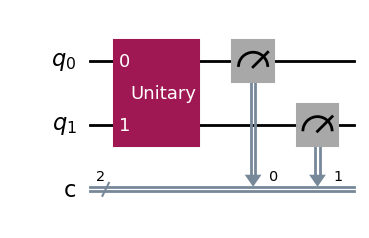

In [3]:
# Build a 2-qubit operator from Pauli and add it to a circuit
op_xz = Operator(Pauli("XZ"))
print("is_unitary:", op_xz.is_unitary())

qc2 = QuantumCircuit(2,2)
qc2.append(op_xz, [0,1])
qc2.measure([0,1],[0,1])
qc2.draw("mpl")

## 4) Combining Operators
### 4.1 Tensor vs Expand
`A.tensor(B)` places **B** on subsystem 0, **A** on subsystem 1.
`A.expand(B)` is the reverse: **A** on subsystem 0, **B** on subsystem 1.

In [4]:
A = Operator(Pauli("X"))
B = Operator(Pauli("Z"))

ten = A.tensor(B)   # B on qubit 0, A on qubit 1
exp = A.expand(B)   # A on qubit 0, B on qubit 1
print("tensor dims:", ten.input_dims(), " expand dims:", exp.input_dims())

tensor dims: (2, 2)  expand dims: (2, 2)


### 4.2 Composition (matrix multiplication)
`A.compose(B)` returns the operator with matrix **B·A** (apply B after A). Set `front=True` for **A·B**.

In [5]:
Xop = Operator(Pauli("X"))
Zop = Operator(Pauli("Z"))
post = Xop.compose(Zop)            # Z then X  (matrix Z·X)
pre  = Xop.compose(Zop, front=True) # X then Z  (matrix X·Z)
print("compose (post)\n", post.data)
print("compose (pre)\n", pre.data)

compose (post)
 [[ 0.+0.j  1.+0.j]
 [-1.+0.j  0.+0.j]]
compose (pre)
 [[ 0.+0.j -1.+0.j]
 [ 1.+0.j  0.+0.j]]


### 4.3 Subsystem composition with `qargs`
Target a subset of qubits when composing a smaller operator into a larger one.

In [6]:
# 3-qubit identity, compose a 2-qubit op on (qubits 0 and 2)
big = Operator(np.eye(2**3))
YI = Operator(Pauli("YI"))
placed = big.compose(YI, qargs=[0,2])
print("placed input dims:", placed.input_dims())

placed input dims: (2, 2, 2)


## 5) Linear combinations & unitarity
Linear combinations generally **break unitarity**. Useful for building observables or maps (not gates).

In [7]:
XX = Operator(Pauli("XX"))
YY = Operator(Pauli("YY"))
ZZ = Operator(Pauli("ZZ"))

H_like = 0.25*XX + 0.25*YY + 0.6*ZZ  # Hermitian combo
print("Hermitian?", np.allclose(H_like.data, H_like.data.conj().T))
print("Unitary?  ", H_like.is_unitary())

Hermitian? True
Unitary?   False


## 6) Implicit conversion
Many `Operator` methods accept raw matrices/lists and convert implicitly.

In [8]:
res = Operator(np.eye(2)).compose([[0,1],[1,0]])  # compose with X matrix directly
print(res.data)

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]


## 7) Comparing operators
- `==` compares elementwise (global phase **counts** as different).
- `process_fidelity` ignores global phase for unitaries/channels.

In [9]:
op_x = Operator(XGate())
op_x_phase = np.exp(1j*0.37) * op_x
print("Equal with phase?", op_x == op_x_phase)
print("Process fidelity:", process_fidelity(op_x, op_x_phase))

Equal with phase? False
Process fidelity: 1.0


## 8) Mini‑exercise
**Task.**
1) Build a 3‑qubit operator `W` that applies `X` on qubit 2 and `Z` on qubit 0 (identity on qubit 1), using **one** `compose(..., qargs=...)` call.
2) Verify `W` equals `Operator(Pauli("XIZ")).expand(Operator(np.eye(2)))` up to exact equality.

<details>
<summary><b>Show solution</b></summary>

```python
W = Operator(np.eye(2**3))
XZ_local = Operator(Pauli("XZ"))   # acts on a 2-qubit slice we will map to (0,2)
W = W.compose(XZ_local, qargs=[0,2])

# Build a reference by explicit tensor layout: (qubit order 0,1,2)
ref = Operator(Pauli("XIZ"))
print(np.allclose(W.data, ref.data))
```

</details>

## Additional information

**Created by:** Ricard Santiago Raigada García

**Version:** 1.0.0